# Imports

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
from scipy.stats import norm
from datetime import datetime, timedelta
import random

from ab_testing.constants import client_name, target_col
from ab_testing.data_acquisition.acquire_data import queries_dict  # AcquireData
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from ab_testing.predictions.produce_predictions import ProducePredictions
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

In [2]:
configure_offline_feature_store(workgroup="development", catalog_name="production")

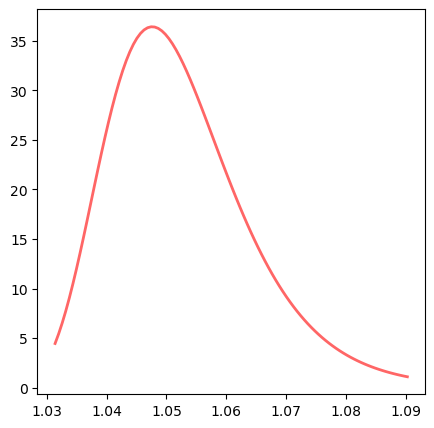

In [3]:
alpha = 20
beta = 1

fig, ax = plt.subplots(figsize = (5,5))
x = np.linspace(scipy.stats.invgamma.ppf(0.01, alpha, 1/beta),
                scipy.stats.invgamma.ppf(0.99, alpha, 1/beta), 100)
ax.plot(x, scipy.stats.invgamma.pdf(x, alpha, 1/beta),
       'r-', lw=2, alpha=0.6, label='norm pdf')

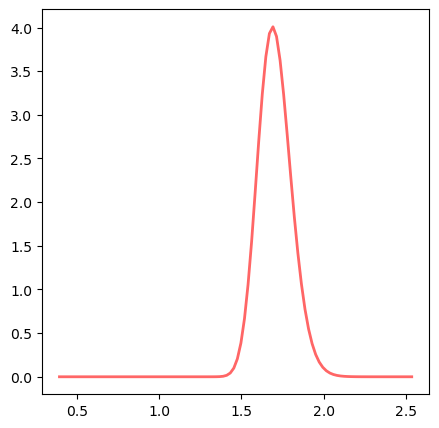

In [4]:
fig, ax = plt.subplots(figsize = (5,5))
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s = 0.4),
                scipy.stats.lognorm.ppf(0.99, s = 0.4), 100)
ax.plot(x, scipy.stats.lognorm.pdf(x, 0.1, 0.7),
       'r-', lw=2, alpha=0.6, label='norm pdf')

In [5]:
list_beta_priors = [(1,1), (3,20), (0.1,9.9), (10,990)]
list_conversion_rates = [(0.01, 0.01), (0.01, 0.015), (0.01, 0.011), ((0.01, 0.0105))]
list_num_points = [1000, 10000, 100000, 1000000]

In [6]:
list_true_means_rates = [(np.sqrt(10), np.sqrt(10)), (np.sqrt(10), np.sqrt(11)), (np.sqrt(10), np.sqrt(10.1))]
list_num_points = [1000, 10000, 100000, 1000000]

In [7]:
A_revenue = np.random.normal(3.5,1, 100000)
A_revenue = np.exp(A_revenue)
A = np.random.binomial(1, 0.01, 100000).astype(float)
A[A>0] = A_revenue[A>0]


B_revenue = np.random.normal(3.5,1, 100000)
B_revenue = np.exp(B_revenue)
B = np.random.binomial(1, 0.01, 100000).astype(float)
B[B>0] = B_revenue[B>0]

In [8]:
# CONVERSION RATE TEST
test_revenue = DeltaLognormalDataTest()

test_revenue.add_variant_data(name = "A", data = A, a_prior_beta = 0.1, b_prior_beta = 9.9, m_prior = 1, a_prior_ig = 0, b_prior_ig = 0, w_prior = 10)
test_revenue.add_variant_data(name = "B", data = B, a_prior_beta = 0.1, b_prior_beta = 9.9, m_prior = 1, a_prior_ig = 0, b_prior_ig = 0, w_prior = 10)

res_revenue_test = test_revenue.evaluate(seed=42)

In [9]:
res_revenue_test

[{'variant': 'A',
  'totals': 100000,
  'positives': 1016,
  'sum_values': 56962.93693,
  'avg_values': 0.56963,
  'avg_positive_values': 56.06588,
  'prob_being_best': 0.424,
  'expected_loss': 0.0200474,
  'expected_total_gain': -0.0075213},
 {'variant': 'B',
  'totals': 100000,
  'positives': 1033,
  'sum_values': 58355.03925,
  'avg_values': 0.58355,
  'avg_positive_values': 56.49084,
  'prob_being_best': 0.576,
  'expected_loss': 0.0125261,
  'expected_total_gain': 0.0075213}]

In [26]:
w_priors_list = [100, 1000, 10000, 100000]


big_list_probabs_2 = []
big_list_results_2 = []

for i, w_prior_i in enumerate(w_priors_list):
        print(i)
        list_probabs = []
        list_results = []
        for k in range(1000):
            A_revenue = np.random.normal(3.5,1, 10000)
            A_revenue = np.exp(A_revenue)
            A = np.random.binomial(1, 0.01, 10000).astype(float)
            A[A>0] = A_revenue[A>0]

            B_revenue = np.random.normal(3.6,1, 10000)
            B_revenue = np.exp(B_revenue)
            B = np.random.binomial(1, 0.01, 10000).astype(float)
            B[B>0] = B_revenue[B>0]
            
        
            test_revenue = DeltaLognormalDataTest()
            test_revenue.add_variant_data(name = "P", data = A, a_prior_beta = 0.1, b_prior_beta = 9.9, m_prior = 3.5, a_prior_ig = 0, b_prior_ig = 0, w_prior = w_prior_i)
            test_revenue.add_variant_data(name = "C", data = B, a_prior_beta = 0.1, b_prior_beta = 9.9, m_prior = 3.6, a_prior_ig = 0, b_prior_ig = 0, w_prior = w_prior_i)

            res_conv_test = test_revenue.evaluate(seed=42)
            list_probabs.append(res_conv_test[0]['prob_being_best'])
            list_results.append(res_conv_test)

        big_list_probabs_2.append(list_probabs)
        big_list_results_2.append(list_results)

0
1
2
3


<AxesSubplot:ylabel='Count'>

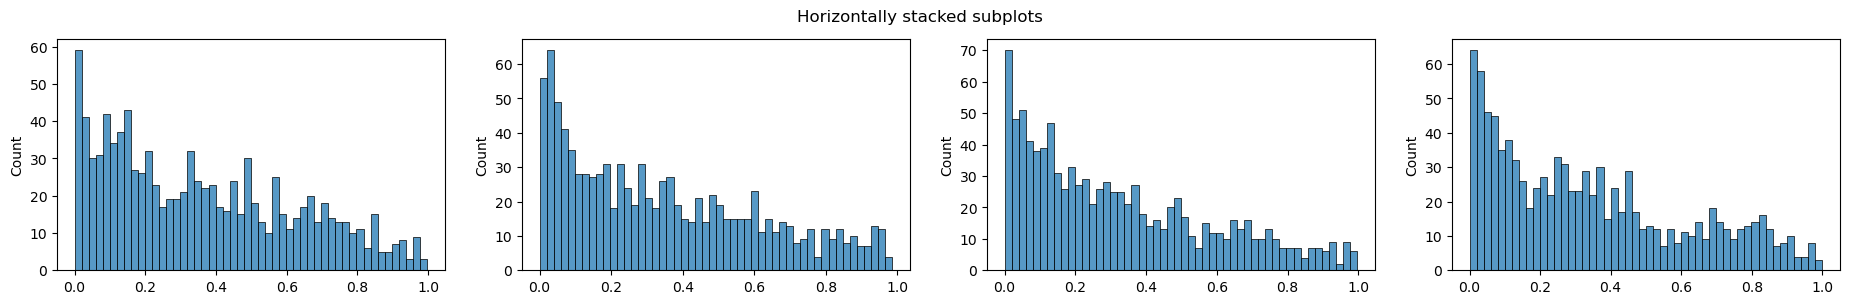

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(23, 3))
fig.suptitle('Horizontally stacked subplots')
sns.histplot(big_list_probabs_2[0], bins = 50, ax = ax[0])
sns.histplot(big_list_probabs_2[1], bins = 50, ax = ax[1])
sns.histplot(big_list_probabs_2[2], bins = 50, ax = ax[2])
sns.histplot(big_list_probabs_2[3], bins = 50, ax = ax[3])

<AxesSubplot:ylabel='Count'>

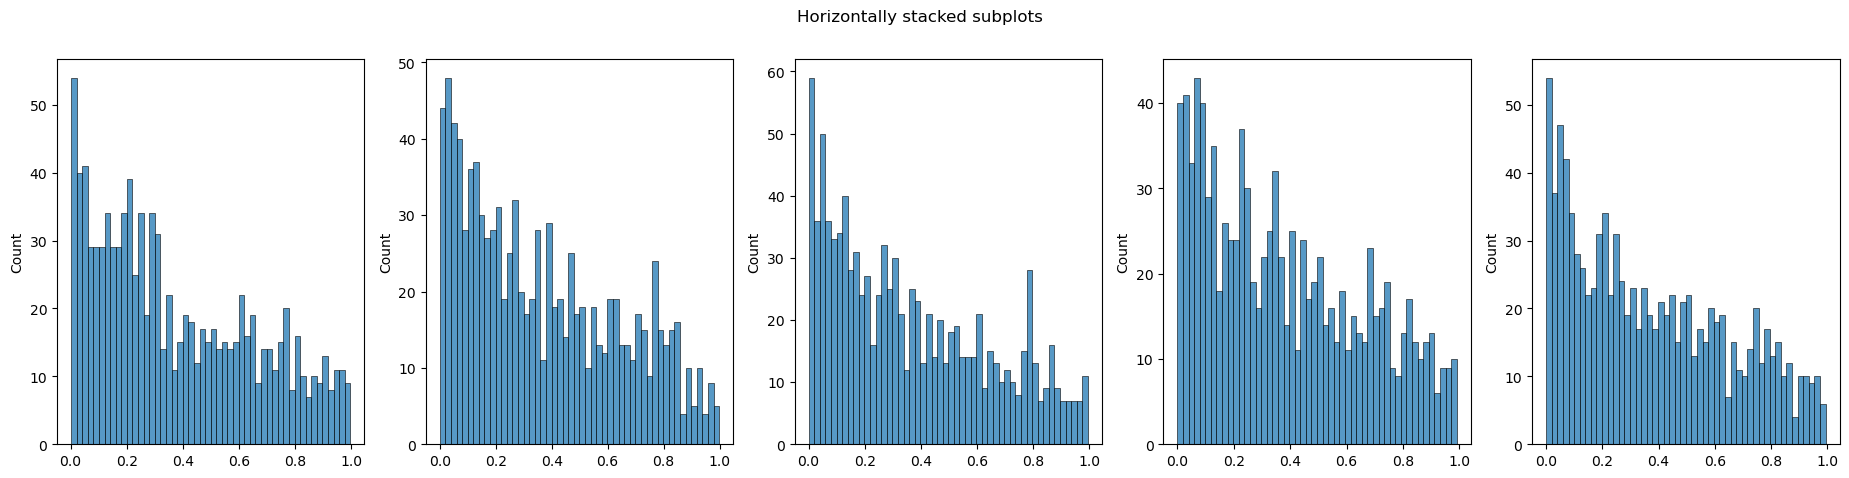

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(23, 5))
fig.suptitle('Horizontally stacked subplots')
sns.histplot(big_list_probabs_2[0], bins = 50, ax = ax[0])
sns.histplot(big_list_probabs_2[1], bins = 50, ax = ax[1])
sns.histplot(big_list_probabs_2[2], bins = 50, ax = ax[2])
sns.histplot(big_list_probabs_2[3], bins = 50, ax = ax[3])
sns.histplot(big_list_probabs_2[4], bins = 50, ax = ax[4])

<AxesSubplot:ylabel='Count'>

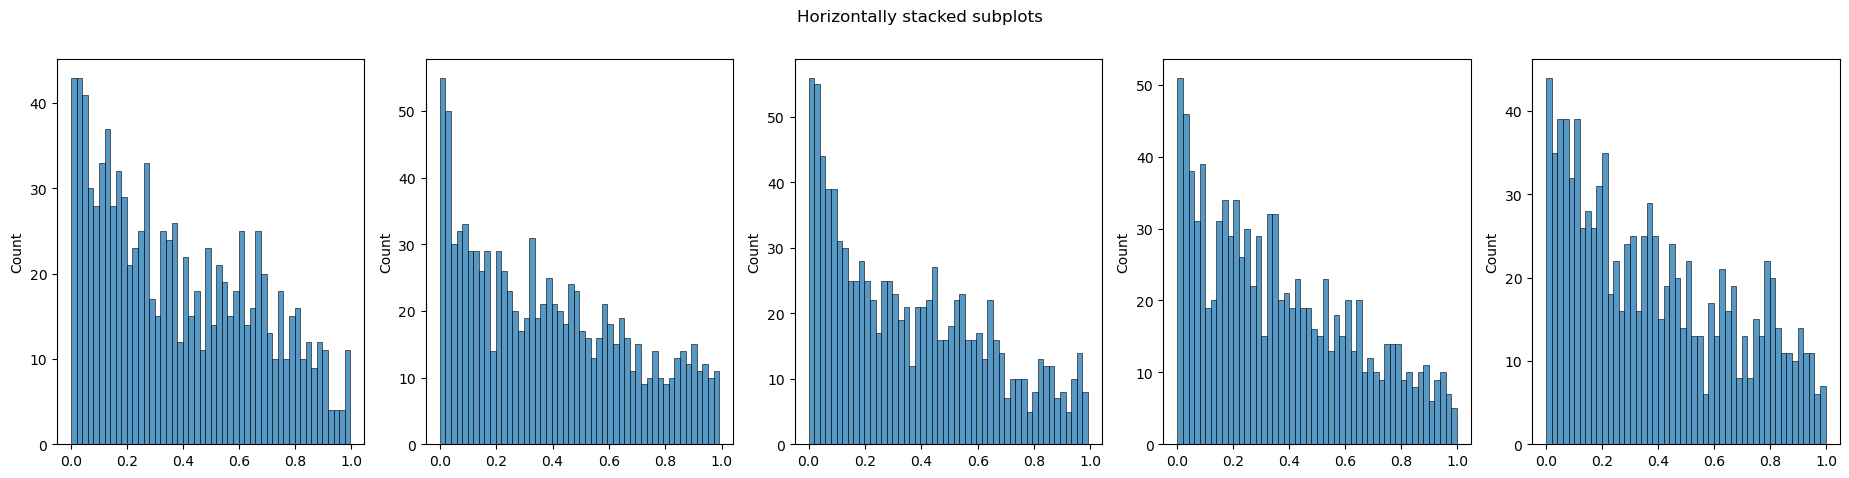

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(23, 5))
fig.suptitle('Horizontally stacked subplots')
sns.histplot(big_list_probabs_2[0], bins = 50, ax = ax[0])
sns.histplot(big_list_probabs_2[1], bins = 50, ax = ax[1])
sns.histplot(big_list_probabs_2[2], bins = 50, ax = ax[2])
sns.histplot(big_list_probabs_2[3], bins = 50, ax = ax[3])
sns.histplot(big_list_probabs_2[4], bins = 50, ax = ax[4])

<AxesSubplot:ylabel='Count'>

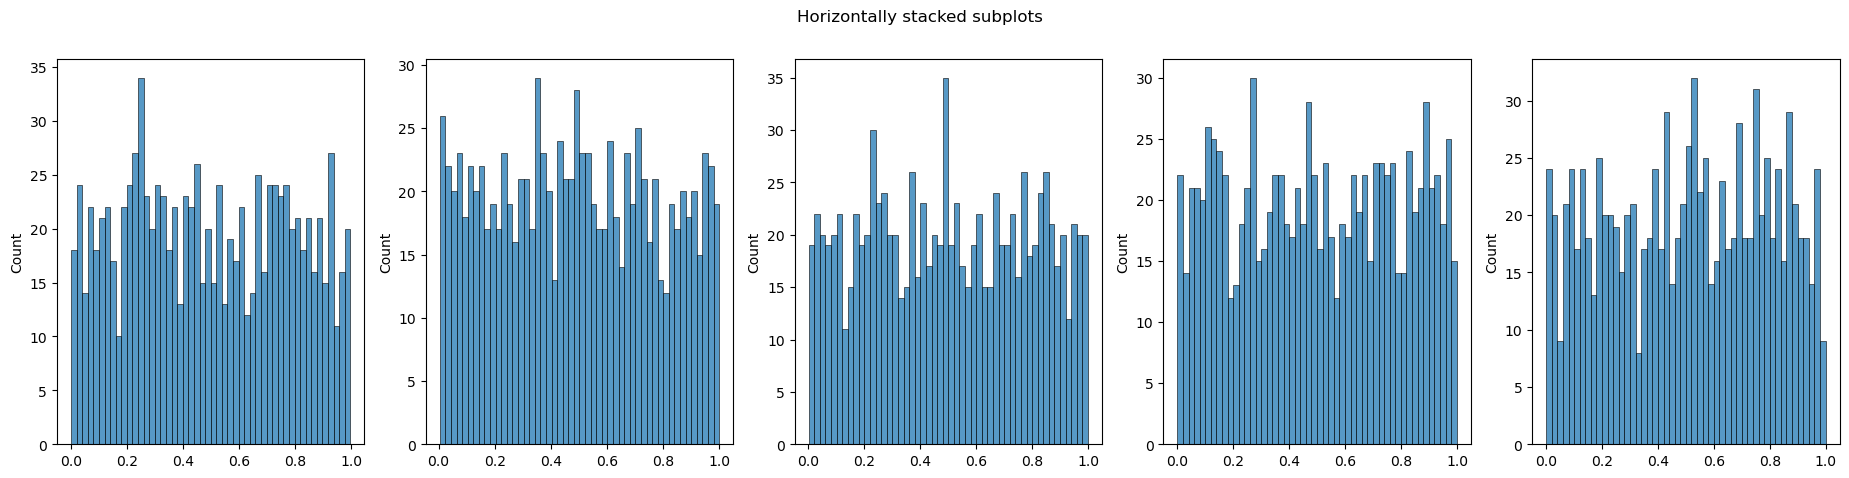

In [21]:
fig, ax = plt.subplots(1, 5, figsize=(23, 5))
fig.suptitle('Horizontally stacked subplots')
sns.histplot(big_list_probabs_2[0], bins = 50, ax = ax[0])
sns.histplot(big_list_probabs_2[1], bins = 50, ax = ax[1])
sns.histplot(big_list_probabs_2[2], bins = 50, ax = ax[2])
sns.histplot(big_list_probabs_2[3], bins = 50, ax = ax[3])
sns.histplot(big_list_probabs_2[4], bins = 50, ax = ax[4])

C:\Users\karol\AppData\Local\Temp\ipykernel_21804\3017579264.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, scipy.stats.lognorm.pdf(x, s = 1.5, loc = 0.7, scale = 1),


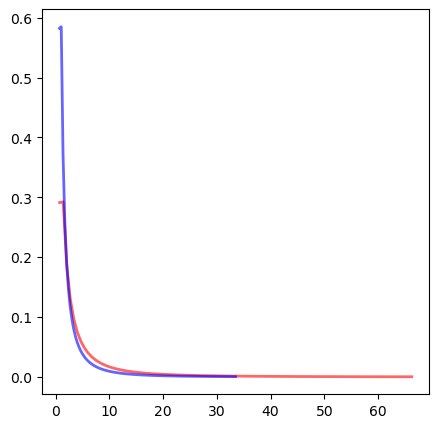

In [14]:
fig, ax = plt.subplots(figsize = (5,5))
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s = 1.5, loc = 0.7, scale = 2),
                scipy.stats.lognorm.ppf(0.99, s = 1.5, loc = 0.7, scale = 2), 100)
ax.plot(x, scipy.stats.lognorm.pdf(x, s = 1.5, loc = 0.7, scale = 2),
       'r-', lw=2, alpha=0.6, label='norm pdf')

x = np.linspace(scipy.stats.lognorm.ppf(0.01, s = 1.5, loc = 0.7, scale = 1),
                scipy.stats.lognorm.ppf(0.99, s = 1.5, loc = 0.7, scale = 1), 100)
ax.plot(x, scipy.stats.lognorm.pdf(x, s = 1.5, loc = 0.7, scale = 1),
       'r-', lw=2, alpha=0.6, label='norm pdf', color = 'blue')

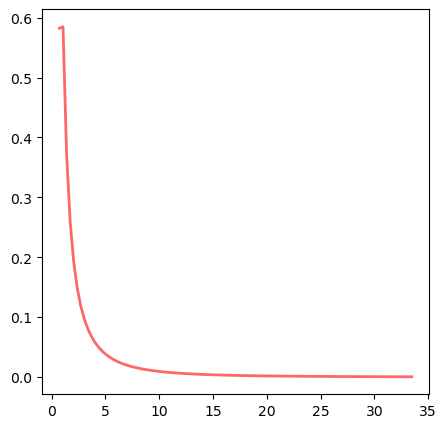

In [12]:
fig, ax = plt.subplots(figsize = (5,5))
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s = 1.5, loc = 0.7, scale = 1),
                scipy.stats.lognorm.ppf(0.99, s = 1.5, loc = 0.7, scale = 1), 100)
ax.plot(x, scipy.stats.lognorm.pdf(x, s = 1.5, loc = 0.7, scale = 1),
       'r-', lw=2, alpha=0.6, label='norm pdf')